### 1. Context. 
Provide a short theoretical background about your research problem with references at the beginning of the Notebook. At the end of the notebook, provide a discussion section and conclusions about the results 
obtained in this assignment. 
##### Grading Criteria: 
- Theoretical background (0.2 points) 
- Discussion of results (0.2 points) 
- Conclusions (0.1 points) 

### Theoretical Context

Nowadays, the acquisition and analysis of environmental data is fundamental for the development of intelligent climate monitoring systems. One of the most critical parameters in this field is relative humidity, as it influences sectors such as agriculture, water management and quality control in industries sensitive to environmental conditions.

This project focuses on the collection and analysis of climate data obtained using an Arduino Nano 33 BLE Sense equipped with pressure, humidity, temperature and rain detection sensors. The aim is to develop a Machine Learning model capable of predicting humidity based on the other recorded variables.

To process these data, outlier elimination techniques (outliers), principal component analysis (PCA) for dimensionality reduction, and calculation of the covariance matrix to evaluate relationships between variables will be applied.
This approach will allow obtaining relevant information for the optimization of humidity control systems, improving their accuracy and efficiency through the combination of low-cost hardware and advanced data processing techniques.


In [163]:
# We import the libreries to be used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.integrate import cumulative_trapezoid
from sklearn.decomposition import PCA

### 2. Data loading and initial visualization. 
Choose a dataset and describe the data characteristics. Ensure data are available in a format suitable for matrix/tensor manipulation (e.g., .csv, .wav, .jpeg, etc.).  Explain how and why you chose the dataset. Visualize a representative sample of your data. If it is an image, display an example. Plot the data points if it is a signal or a time series. 
##### Grading Criteria: 
- Proper data loading and handling (0.5 points) 
- Clear and informative visualizations (0.3 points) 

In [164]:
# Loading the database
file_path = "data.csv"
df = pd.read_csv(file_path)



In [165]:
# Review initial data
print(df.head())

               Time_PC  Temperature  Humidity  Pressure  Altitude  Rain
0  2025-03-24 15:27:35        32.65     38.68     84.63  16690.72     1
1  2025-03-24 15:28:33        32.88     38.05     84.64  16690.45     1
2  2025-03-24 15:29:33        32.87     38.52     84.64  16690.55     1
3  2025-03-24 15:30:33        32.58     38.16     84.63  16691.00     1
4  2025-03-24 15:31:33        32.41     37.84     84.64  16690.54     1


### Explanation of the choice of the dataset

The dataset was selected because it contains real-time environmental data obtained with an Arduino Nano 33 BLE Sense. It includes key variables such as:

 - Pressure (hPa)

 - Temperature (°C)

 - Relative humidity (%)

 - Altitude (m)

 - Rainfall (1 = No rain, 0 = There is rain)

The main objective of the analysis is to predict humidity using the other variables. This information is relevant for applications in climate monitoring systems, agriculture and control of environmental conditions in industrial environments.

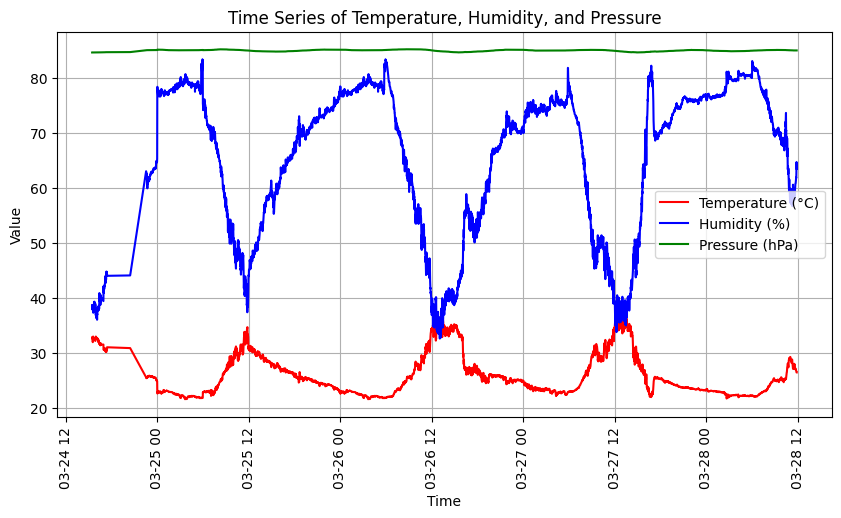

In [166]:
# Convert time column to datetime format
df["Time_PC"] = pd.to_datetime(df["Time_PC"])

# 
plt.figure(figsize=(10, 5))
plt.plot(df["Time_PC"], df["Temperature"], label="Temperature (°C)", color="red")
plt.plot(df["Time_PC"], df["Humidity"], label="Humidity (%)", color="blue")
plt.plot(df["Time_PC"], df["Pressure"], label="Pressure (hPa)", color="green")

# Personalizar la gráfica
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series of Temperature, Humidity, and Pressure")
plt.legend()
plt.xticks(rotation=90)
plt.grid()

# Mostrar gráfica
plt.show()

### 3. [OOP  for  data  processing].  
Implement  an  OOP-based  design  for your  data analysis  pipeline.  Define  at  least  two  classes  related to  your  dataset  (e.g., ImageProcessor, SignalAnalyzer, ControlSystemAnalyzer). Each class should  encapsulate  relevant  methods for  data  manipulation:  for  example,  if working  with  images,  use  methods  for  contrast  or  resizing;  if  working  with signals  or  electrical  variables,  ensure  filtering,  noise  removal,  or  feature extraction. Use Python functions, loops, conditionals, and list 
comprehensions where applicable.  
##### Grading Criteria: 
- Correct application of Python fundamentals (0.2 points) 
-  Effective use of object-oriented principles (0.7 points) 
-  Relevant preprocessing steps (0.4 points)

In [173]:
class DataPreprocessor:
    """Class for data cleaning and preprocessing."""
    
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path)
        self.df["Time_PC"] = pd.to_datetime(self.df["Time_PC"])
            
    def convert_units(self):
        """Converts the pressure from kPa to hPa and recalculates the altitude."""
        self.df["Pressure"] *= 10
        self.df["Altitude"] = 44330 * (1 - (self.df["Pressure"] / 1013.25) ** (1 / 5.255))
    
    def remove_outliers(self, column, threshold=3):
        """Eliminate outliers using the 3 sigma rule."""
        mean = self.df[column].mean()
        std = self.df[column].std()
        self.df = self.df[np.abs(self.df[column] - mean) < threshold * std]
    
    def fill_missing_values(self):
        """Interpolates missing values in the dataset."""
        self.df.interpolate(method='linear', inplace=True)
    
    def get_clean_data(self):
        """Returns the clean dataframe."""
        return self.df

In [174]:
class DataAnalyzer:
    """Class for statistical and graphical data analysis."""
    
    def __init__(self, df):
        self.df = df
    
    def plot_time_series(self):
        """Plots time series for temperature, humidity, and pressure."""
        plt.figure(figsize=(12, 6))
        plt.plot(self.df["Time_PC"], self.df["Temperature"], label="Temperature (°C)", color="red")
        plt.plot(self.df["Time_PC"], self.df["Humidity"], label="Humidity (%)", color="blue")
        plt.plot(self.df["Time_PC"], self.df["Pressure"], label="Pressure (hPa)", color="green")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.title("Time Series of Temperature, Humidity, and Pressure")
        plt.legend()
        plt.xticks(rotation=90)
        plt.grid()
        plt.show()

    def compute_covariance_matrix(self):
        """Computes the covariance matrix of the dataset."""
        return self.df[["Temperature", "Humidity", "Pressure", "Altitude"]].cov()
    
    def apply_pca(self, n_components=2):
        """Applies Principal Component Analysis (PCA) and plots the results with different colors for 'Rain' values."""
        
        pca = PCA(n_components=n_components, random_state=42)
        
        # Select data and labels
        data = self.df[["Temperature", "Humidity", "Pressure", "Altitude", "Rain"]].dropna()
        labels = data["Rain"]
        transformed_data = pca.fit_transform(data.drop(columns=["Rain"]))  # Aplicar PCA sin la columna de clase
        
        # Define colors: Blue for “Rain” (0), Red for “not Rain” (1)
        colors = {0: 'blue', 1: 'red'}
        labels_dict = {0: 'Rain', 1: 'No Rain'}
        
        plt.figure(figsize=(8, 6))
        
        # Plot each point with its corresponding color
        for Rain in [0, 1]:
            idx = labels == Rain
            plt.scatter(transformed_data[idx, 0], transformed_data[idx, 1], 
                    color=colors[Rain], label=f"{labels_dict[Rain]} ({colors[Rain]})", alpha=0.25)
    
        
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.title("PCA - Dimensionality Reduction (Rain vs No Rain)")
        plt.legend()
        plt.grid()
        plt.show()

In [175]:
# Usage of the classes
preprocessor = DataPreprocessor("data.csv")
preprocessor.remove_outliers("Pressure")
preprocessor.convert_units()
preprocessor.fill_missing_values()
df_clean = preprocessor.get_clean_data()

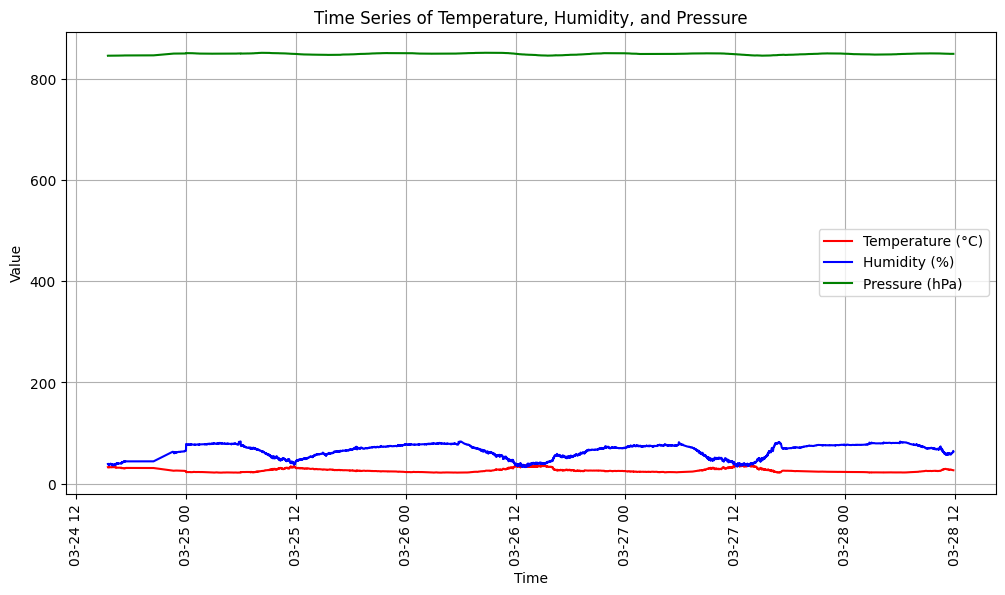

Covariance Matrix:
              Temperature    Humidity   Pressure    Altitude
Temperature    13.546891  -47.466840  -2.254194   21.659955
Humidity      -47.466840  177.249390   7.754804  -74.525716
Pressure       -2.254194    7.754804   2.048206  -19.672037
Altitude       21.659955  -74.525716 -19.672037  188.940627


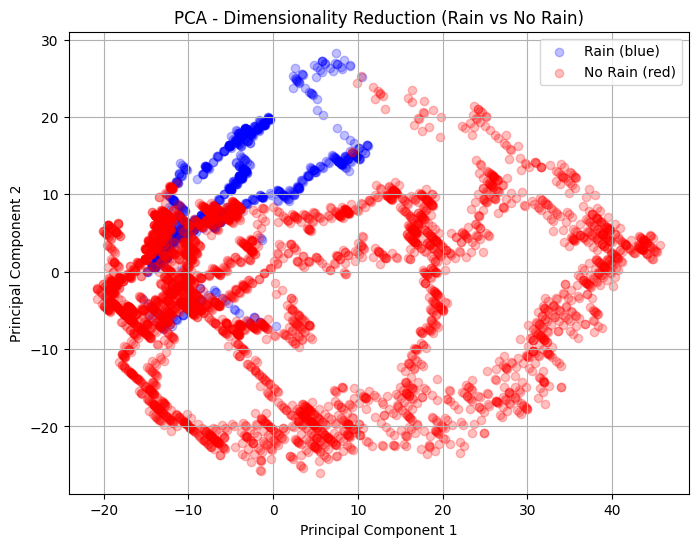

In [176]:
analyzer = DataAnalyzer(df_clean)
analyzer.plot_time_series()
print("Covariance Matrix:\n", analyzer.compute_covariance_matrix())
analyzer.apply_pca()

### 5. Numerical derivation or integration of data. 
Implement a numerical derivative calculation  or  integration  on  your  dataset.  For  images,  the  derivative  could involve computing gradients or edge detection using finite difference methods. The integration computes cumulative intensity values or integrates over pixel values in specific regions. 
For  signals  or  control  systems  data,  the  derivative  calculates  the  rate  of change  over  time  (e.g.,  current  or  voltage  over  time),  whilst  the  integration can compute the total energy consumption or signal area under the curve. Visualize the results of the derivative.
##### Grading Criteria: 
-  Correct implementation of numerical calculations (0.6 points). 
-  Clear visualization and explanation of results (0.6 points).

In [216]:
class Integrator:
    def __init__(self, a, b, n):
        self.a, self.b, self.n = a, b, n
        self.points, self.weights = self.construct_method()

    def construct_method(self):
        raise NotImplementedError('No rule in class %s' % self.__class__.__name__)

    def integrate(self, f):
        return np.dot(self.weights, f(self.points))

# Regla del trapecio
class Trapezoidal(Integrator):
    def construct_method(self):
        h = (self.b - self.a) / (self.n - 1)  # Paso entre puntos
        w = np.zeros(self.n) + h  # Pesos
        w[0] = h / 2
        w[-1] = h / 2
        x = np.linspace(self.a, self.a + (self.n - 1) * h, self.n)  # Puntos
        return x, w
    
# Análisis numérico con integración
class NumericalAnalysis:
    def __init__(self, df):
        self.df = df

    def compute_integral(self, x_column, y_column):
        """Calcula la integral de y respecto a x usando la regla del trapecio."""
        x = self.df[x_column].values
        y = self.df[y_column].values

        # Definir límites de integración
        a, b = x.min(), x.max()
        n = len(x)

        # Crear objeto de integración y calcular
        integrator = Trapezoidal(a, b, n)
        integral_value = integrator.integrate(lambda t: np.interp(t, x, y))

        self.df[f"{y_column}_integral"] = integral_value
        return integral_value

    def plot_integral(self, x_column, y_column):
        """Grafica la integral de y respecto a x."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.df[x_column], self.df[f"{y_column}_integral"], label=f"Integral of {y_column} wrt {x_column}", color="green")
        plt.xlabel(x_column)
        plt.ylabel(f"Cumulative {y_column}")
        plt.title(f"Integral of {y_column} with respect to {x_column}")
        plt.legend()
        plt.grid()
        plt.show()
    
    def plot_datos(self, x_column, y_column):
        """Grafica la integral de y respecto a x."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.df[x_column], self.df[f"{y_column}"], label=f"Plot of {y_column} Vs {x_column}", color="red")
        plt.xlabel(x_column)
        plt.ylabel(f"Cumulative {y_column}")
        plt.title(f"Integral of {y_column} with respect to {x_column}")
        plt.legend()
        plt.grid()
        plt.show()


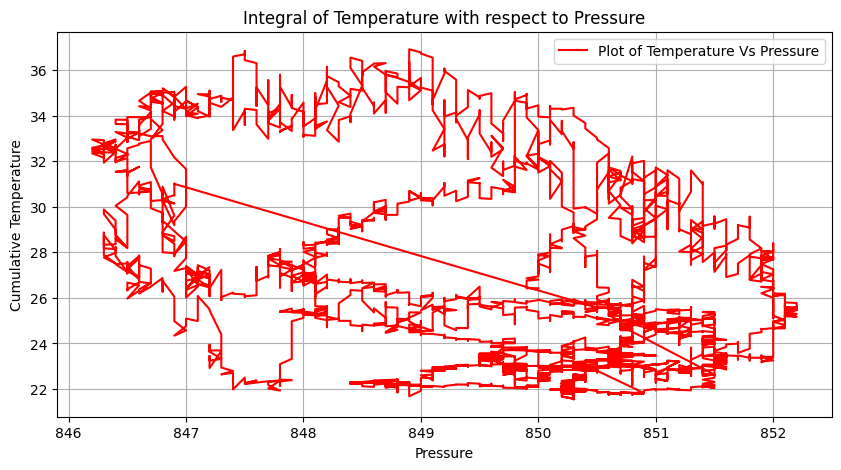

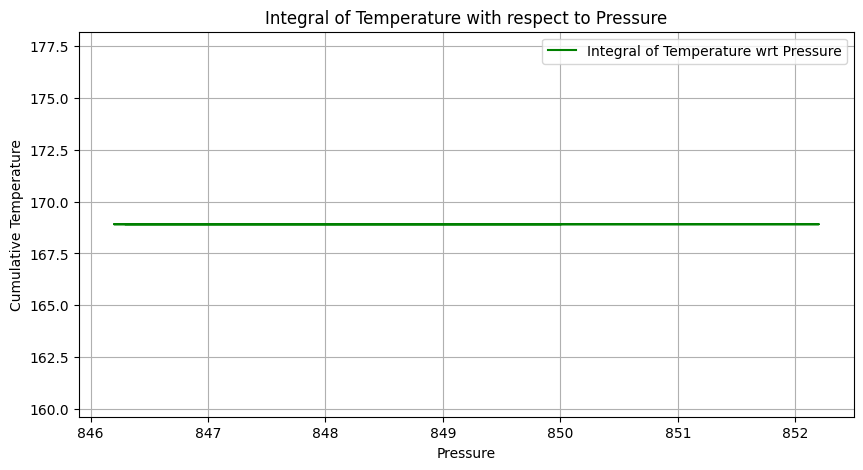

In [218]:
numerical_analysis = NumericalAnalysis(df_clean)
integral_value = numerical_analysis.compute_integral("Pressure" , "Temperature")
numerical_analysis.plot_datos("Pressure" , "Temperature")
numerical_analysis.plot_integral("Pressure" , "Temperature")




### 5. Matrix operations.
 Perform matrix or tensor operations on your data. For  images,  treat  them  as  matrices  and  apply  operations  such  as  matrix multiplication, tensor slicing, or eigenvalue computation. 
For signals or electrical data, represent the data as matrices or higher-dimensional  tensors  and  apply  similar  operations  (e.g.,  matrix  multiplication, decomposition, or transformation). 
##### Grading Criteria: 
- Correct implementation of matrix or tensor operations (0.8 points). 
- Clear explanation of results and relevance to the data (0.4 points). 

In [222]:
class MatrixAnalysis:
    def __init__(self, df, columns):
        """
        Initializes the class with the DataFrame and selected columns.

        Parameters:
        - df: Pandas DataFrame containing the data.
        - columns: List of column names to analyze.
        """
        self.df = df.dropna(subset=columns)  # Remove rows with NaN values
        self.columns = columns
        self.data_matrix = self.df[columns].values
        self.cov_matrix = None
        self.eigenvalues = None
        self.eigenvectors = None

    def compute_covariance_matrix(self):
        """Computes the covariance matrix."""
        self.cov_matrix = np.cov(self.data_matrix.T)
        return self.cov_matrix

    def compute_eigen_decomposition(self):
        """Computes the eigenvalues and eigenvectors of the covariance matrix."""
        if self.cov_matrix is None:
            self.compute_covariance_matrix()
        self.eigenvalues, self.eigenvectors = np.linalg.eig(self.cov_matrix)
        return self.eigenvalues, self.eigenvectors

    def print_results(self):
        """Prints the covariance matrix, eigenvalues, and eigenvectors."""
        print("Covariance Matrix:\n", self.cov_matrix)
        print("\nEigenvalues:\n", self.eigenvalues)
        print("\nEigenvectors:\n", self.eigenvectors)

    def plot_eigenvectors(self):
        """Plots the data and overlays the eigenvectors."""
        if self.eigenvalues is None or self.eigenvectors is None:
            self.compute_eigen_decomposition()
        
        plt.scatter(self.data_matrix[:, 0], self.data_matrix[:, 1], alpha=0.5, label="Data")
        origin = np.mean(self.data_matrix, axis=0)  # Compute the data center

        # Draw eigenvectors
        for i in range(len(self.eigenvalues)):
            plt.quiver(*origin, 
                       *self.eigenvectors[:, i] * np.sqrt(self.eigenvalues[i]), 
                       color=['r', 'b'][i], scale=3, label=f"Eigenvector {i+1}")

        plt.xlabel(self.columns[0])
        plt.ylabel(self.columns[1])
        plt.legend()
        plt.title("Eigenvalues and Eigenvectors of the Covariance Matrix")
        plt.show()

Covariance Matrix:
 [[177.24939018 -47.46683968]
 [-47.46683968  13.54689122]]

Eigenvalues:
 [190.0169967   0.7792847]

Eigenvectors:
 [[ 0.96567665  0.25974722]
 [-0.25974722  0.96567665]]


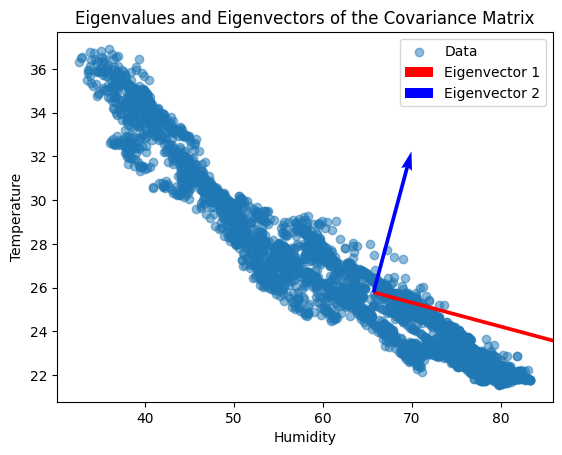

In [224]:
# Create an instance of the class with Pressure and Temperature data
matrix_analysis = MatrixAnalysis(numerical_analysis.df, ["Humidity", "Temperature"])

# Compute covariance matrix and eigen decomposition
matrix_analysis.compute_covariance_matrix()
matrix_analysis.compute_eigen_decomposition()

# Print results
matrix_analysis.print_results()

# Plot the eigenvectors over the data
matrix_analysis.plot_eigenvectors()



### Covariance Matrix
Diagonal elements (177.25, 13.55) represent the variance of Humidity and Temperature, respectively.

-  Humidity has a much larger variance than Temperature, meaning it fluctuates more in the dataset.

Off-diagonal elements (-47.47) indicate a negative correlation between Humidity and Temperature.

- This suggests that as Humidity increases, Temperature decreases, which aligns with typical environmental behavior (e.g., humid conditions often bring cooler temperatures

### Eigenvalues
- The first eigenvalue (190.02) is significantly larger than the second (0.78), meaning that most of the variance in the data is along one direction (the first eigenvector).

- The second eigenvalue (0.78) is much smaller, meaning there is very little variance in that direction.

#### Conclusion:

- This indicates that the dataset is highly linear, meaning Humidity and Temperature are strongly correlated.

### Eigenvectors
-   The first eigenvector ([0.966, -0.26], red) is the principal direction of variance, meaning most of the data follows this trend.

-  The second eigenvector ([0.26, 0.966], blue) represents the minor variance in the dataset.

Since the first eigenvector has a much higher eigenvalue, it aligns with Humidity, confirming that Humidity is the dominant variable affecting the dataset.